# Multi-label text classifier

Data: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data

In [1]:
%matplotlib inline
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns
df = pd.read_csv('./data/train.csv', encoding='ISO-8859-1')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
df2 = pd.read_csv('data/vzn/TrainingData.csv', encoding='ISO-8859-1')
df2.head()

,Search Query,Coded Terms,Term 1,Term 2,Term 3,Term 4,Term 5,Term 6,Term 7,Term 8,Term 9,Sum of Impressions
0,verizon,brand,brand,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46304722
1,verizon wireless,brand,brand,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33455658
2,iphone 7,"phones, apple, iphone, iphone 7",phones,apple,iphone,iphone 7,NaN,NaN,NaN,NaN,NaN,6586498
3,iphone 7 plus,"phones, apple, iphone, iphone 7, iphone 7 plus",phones,apple,iphone,iphone 7,iphone 7 plus,NaN,NaN,NaN,NaN,5694394
4,my verizon,"brand, my verizon",brand,my verizon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3503391


### Number of comments in each category

In [2]:
df_toxic = df.drop(['id', 'comment_text'], axis=1)
counts = []
categories = list(df_toxic.columns.values)
for i in categories:
    counts.append((i, df_toxic[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405


Text(0.5, 0, 'category')

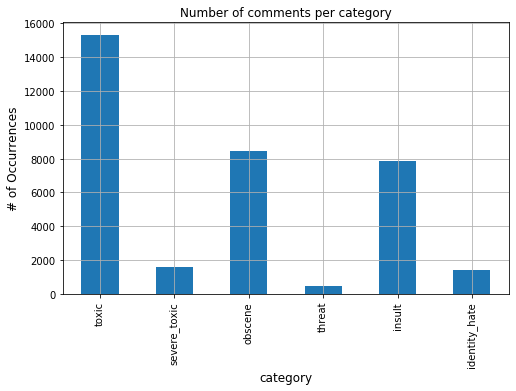

In [3]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

### Multilabels

Text(0.5, 0, '# of categories')

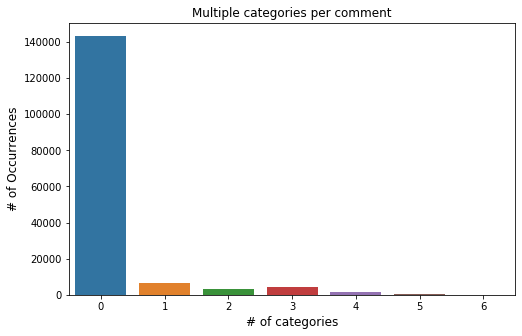

In [4]:
rowsums = df.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

### Not labeled

In [5]:
print('Percentage of comments that are not labelled:')
print(len(df[(df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) & (df['threat']== 0) & (df['insult']==0) & (df['identity_hate']==0)]) / len(df))

Percentage of comments that are not labelled:
0.8983211235124177


### The distribution of the number of words in comment texts

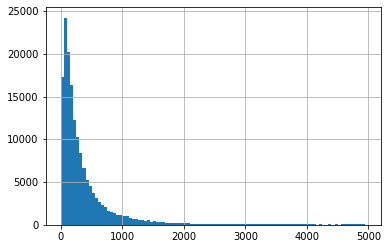

In [6]:
lens = df.comment_text.str.len()
lens.hist(bins = np.arange(0,5000,50))

### Missing comments

In [8]:
print('Number of missing comments in comment text:')
df['comment_text'].isnull().sum()

Number of missing comments in comment text:


0

### First comment

In [9]:
df['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

## Data preprocessing

### Clean text

In [10]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

### Clean up comment_text column

In [12]:
df['comment_text'] = df['comment_text'].map(lambda com : clean_text(com))
df['comment_text'][0]

'explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now 89 205 38 27'

### Create "train" and "test" sets

In [13]:
categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train, test = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)
X_train = train.comment_text
X_test = test.comment_text
print(X_train.shape)
print(X_test.shape)

(106912,)
(52659,)


## Classifiers training

### Naive bayes

In [15]:
# Define a pipeline combining a text feature extractor with multi lable classifier
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing toxic
Test accuracy is 0.9192350785240889
... Processing severe_toxic
Test accuracy is 0.9900112041626312
... Processing obscene
Test accuracy is 0.9515752293055318
... Processing threat
Test accuracy is 0.9971135038644866
... Processing insult
Test accuracy is 0.9517271501547694
... Processing identity_hate
Test accuracy is 0.9910556600011394


### LinearSVC

In [16]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing toxic
Test accuracy is 0.9600068364382157
... Processing severe_toxic
Test accuracy is 0.9906948479842003
... Processing obscene
Test accuracy is 0.9788830019559809
... Processing threat
Test accuracy is 0.9974363356691164
... Processing insult
Test accuracy is 0.971135038644866
... Processing identity_hate
Test accuracy is 0.9919861752027194


In [17]:
### Logistic Regression

In [18]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing toxic
Test accuracy is 0.9548415275641391
... Processing severe_toxic
Test accuracy is 0.9910746501072941
... Processing obscene
Test accuracy is 0.9760724662450863
... Processing threat
Test accuracy is 0.9973603752444976
... Processing insult
Test accuracy is 0.9687422852693747
... Processing identity_hate
Test accuracy is 0.991758293928863
